# First Steps Into the Project
    - Reading the tabular data
    - Reading the raster file and the information it contains
    - Displaying the tiles on the raster file 

### Setting working directory

In [1]:
import os
os.chdir('../')

### Modules and Libraries Needed

In [56]:
from config import SUBMISSION_SAMPLE, ANALYTICAL, TARGET, COLUMNS_DESCRIPTION, LANDCOVER_MAP, RASTER, SHAPEFILE
import pandas as pd
import numpy as np
import rasterio as rio
import geopandas as gpd
import earthpy as et
from rasterio.plot import show
import gdal
import matplotlib.pyplot as plt
import fiona
import georasters as gr
import earthpy.plot as ep
from rasterio.plot import plotting_extent
import rasterstats as rs
from rasterio.plot import show
import plotly.graph_objects as go

### Tabular Data

In [3]:
analytical_table = pd.read_csv(ANALYTICAL)
target = pd.read_csv(TARGET)
columns_description = pd.read_csv(COLUMNS_DESCRIPTION)
landcover_map = pd.read_csv(LANDCOVER_MAP)
submission_sample = pd.read_csv(SUBMISSION_SAMPLE)

In [4]:
analytical_table.head()

block_size  tile_h  tile_v  empty_area  water_area  urban_area  \
0          33    5412       0        1016          73           0   
1          33    5445       0         654         435           0   
2          33    5478       0         259         526           0   
3          33    5511       0          81         840           0   
4          33    5544       0         317         772           0   

   barren_area  forest_area  shrubland_area  herbaceous_area  ...  \
0            0            0               0                0  ...   
1            0            0               0                0  ...   
2            2          294               0                8  ...   
3           13          146               0                2  ...   
4            0            0               0                0  ...   

   protected_area_taa  elevation  elevation_sd  elevation_min  elevation_max  \
0                   0          0           0.0              0              0   
1                   0          0           0.0              0              0   
2                   0          0           0.0              0              0   
3                   0          0           0.0              0              0   
4                   0          0           0.0              0              0   

   degree_of_slope  degree_of_slope_sd  degree_of_slope_min  \
0                0                 0.0                    0   
1                0                 0.0                    0   
2                0                 0.0                    0   
3                0                 0.0                    0   
4                0                 0.0                    0   

   degree_of_slope_max  has_target  
0                    0           0  
1                    0           0  
2                    0           1  
3                    0           1  
4                    0           1  

[5 rows x 23 columns]

In [6]:
print("The total number of tiles on the state of Wisconsin is {0}".format(len(analytical_table)))

The total number of tiles on the state of Wisconsin is 149751


In [49]:
target.head()

tile_h  tile_v  target
0    5478       0       0
1    5511       0       0
2    5544       0       0
3    5313      33       0
4    5478      33       0

In [7]:
print("We have a target for {0} of these tiles".format(len(target)))

We have a target for 104836 of these tiles


In [9]:
columns_description

column_name                                 column_description
0            block_size          Number of pixels on each side of the tile
1            tile_width  Horizontal coordinate of the bottom left corne...
2           tile_height  Vertical coordinate of the bottom left corner ...
3            empty_area  Number of pixels with no land cover value in t...
4            water_area  Number of pixels that correspond to land_cover...
5            urban_area  Number of pixels that correspond to land_cover...
6           barren_area  Number of pixels that correspond to land_cover...
7           forest_area  Number of pixels that correspond to land_cover...
8        shrubland_area  Number of pixels that correspond to land_cover...
9       herbaceous_area  Number of pixels that correspond to land_cover...
10      cultivated_area  Number of pixels that correspond to land_cover...
11         wetland_area  Number of pixels that correspond to land_cover...
12   protected_area_tnc  Number of pixels that correspond to a protecte...
13   protected_area_taa  Number of pixels that correspond to Transfers ...
14            elevation                           Average elevation (in m)
15         elevation_sd               Standard deviation of the elevation 
16        elevation_min                                  Minimum elevation
17        elevation_max                                 Maximum elevation 
18      degree_of_slope                           Average degree of slope 
19   degree_of_slope_sd         Standard deviation of the degree of slope 
20  degree_of_slope_min                           Minimum degree of slope 
21  degree_of_slope_max                                 Maximum elevation 
22           has_target  Binary column where 1 corresponds to observati...

In [7]:
landcover_map

pixel_value               land_cover_name
0            11                    open_water
1            12         perennial_ice_or_snow
2            21          developed_open_space
3            22       developed_low_intensity
4            23    developed_medium_intensity
5            24      developed_high_intensity
6            31    barren_land_rock_sand_clay
7            41              deciduous_forest
8            42              evergreen_forest
9            43                  mixed_forest
10           51                   dwarf_scrub
11           52                shrub_or_scrub
12           71       grassland_or_herbaceous
13           72           sedge_or_herbaceous
14           73                       lichens
15           74                          moss
16           81                pasture_or_hay
17           82              cultivated_crops
18           90                woody_wetlands
19           95  emergent_herbaceous_wetlands

## Raster File

### Properties of the Raster File

In [79]:
raster = gdal.Open(RASTER)

#print(raster.GetProjection())

# Dimensions
print("This image has {0} on the x-axis and {1} on the y-axis for total image resolutio of {2}p".format(raster.RasterXSize,
                                                                                                         raster.RasterYSize,
                                                                                                         raster.RasterYSize*raster.RasterYSize))
# Number of bands
print("It is a {0}-band raster".format(raster.RasterCount))
      
band1 = raster.GetRasterBand(1)
band2 = raster.GetRasterBand(2)
   

This image has 15857 on the x-axis and 16837 on the y-axis for total image resolutio of 283484569p
It is a 2-band raster


### 2-Band Raster 
    In displaying the two bands, we can see that Band1 gives us the landcover code while Band2 is just an indicator if the pixel is on the state or outside of it

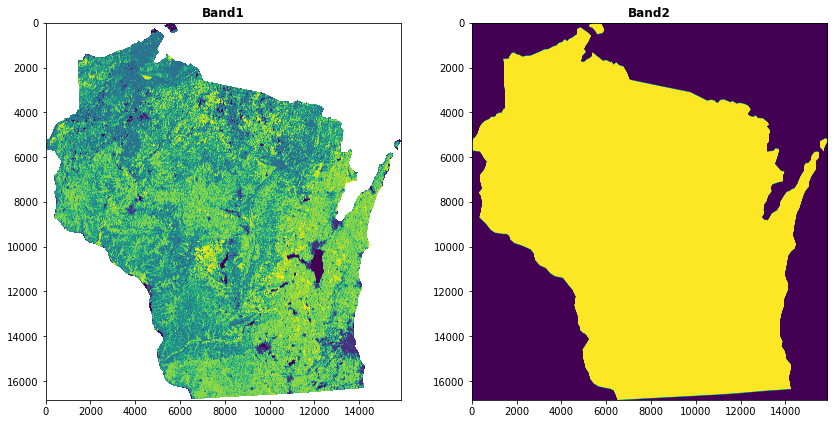

In [20]:
with rio.open(RASTER) as DEM_src:
    fig, (axr, axg) = plt.subplots(1,2, figsize=(14,7))
    show(DEM_src.read(1, masked=True), ax = axr, title = 'Band1')
    show(DEM_src.read(2, masked=True), ax = axg, title = 'Band2')

We can also see that the origin of the file is at the top left corner

### Let's take a closer look at Band1
    Band1 contains the data we need since the tiles always encompass at least some "instate pixels", let us join it with "landcover_map" to look at the spatial distribution of landtypes across the state

In [62]:
with rio.open(RASTER) as DEM_src:
    DEM_data = DEM_src.read(1, masked=False)
    counts = DEM_data.ravel()
    unique, counts = np.unique(counts, return_counts=True)
    unique = [landcover_map.loc[landcover_map['pixel_value'] == u ,['land_cover_name']].values[0][0] if u != 0 else "Na" for u in unique]
    dist = dict(zip(unique, counts))
    del dist['Na']
    dist = {k: v for k, v in sorted(dist.items(), key=lambda item: item[1], reverse=True)}
    x = list(dist.keys())
    y = list(dist.values())
    
    fig = go.Figure(data=[go.Bar(
                x=x, y=y,
                text=y,
                textposition='auto',
            )])
    fig.update_layout(title_text='Land cover type distribution in Wisconsin in 2001')


    fig.show()


### How do the tiles cover the state ?
    This is a supervised learning problem and our observations are the tiles covering the state. Let us plot these tiles on top of the raster file for visualisation purposes. For each blue square that doesn't have a target we will have to predict how many pixels will belong to one of these 4 categories in 2016:
        - developed_open_space
        - developed_low_intensity
        - developed_medium_intensity
        - developed_high_intensity

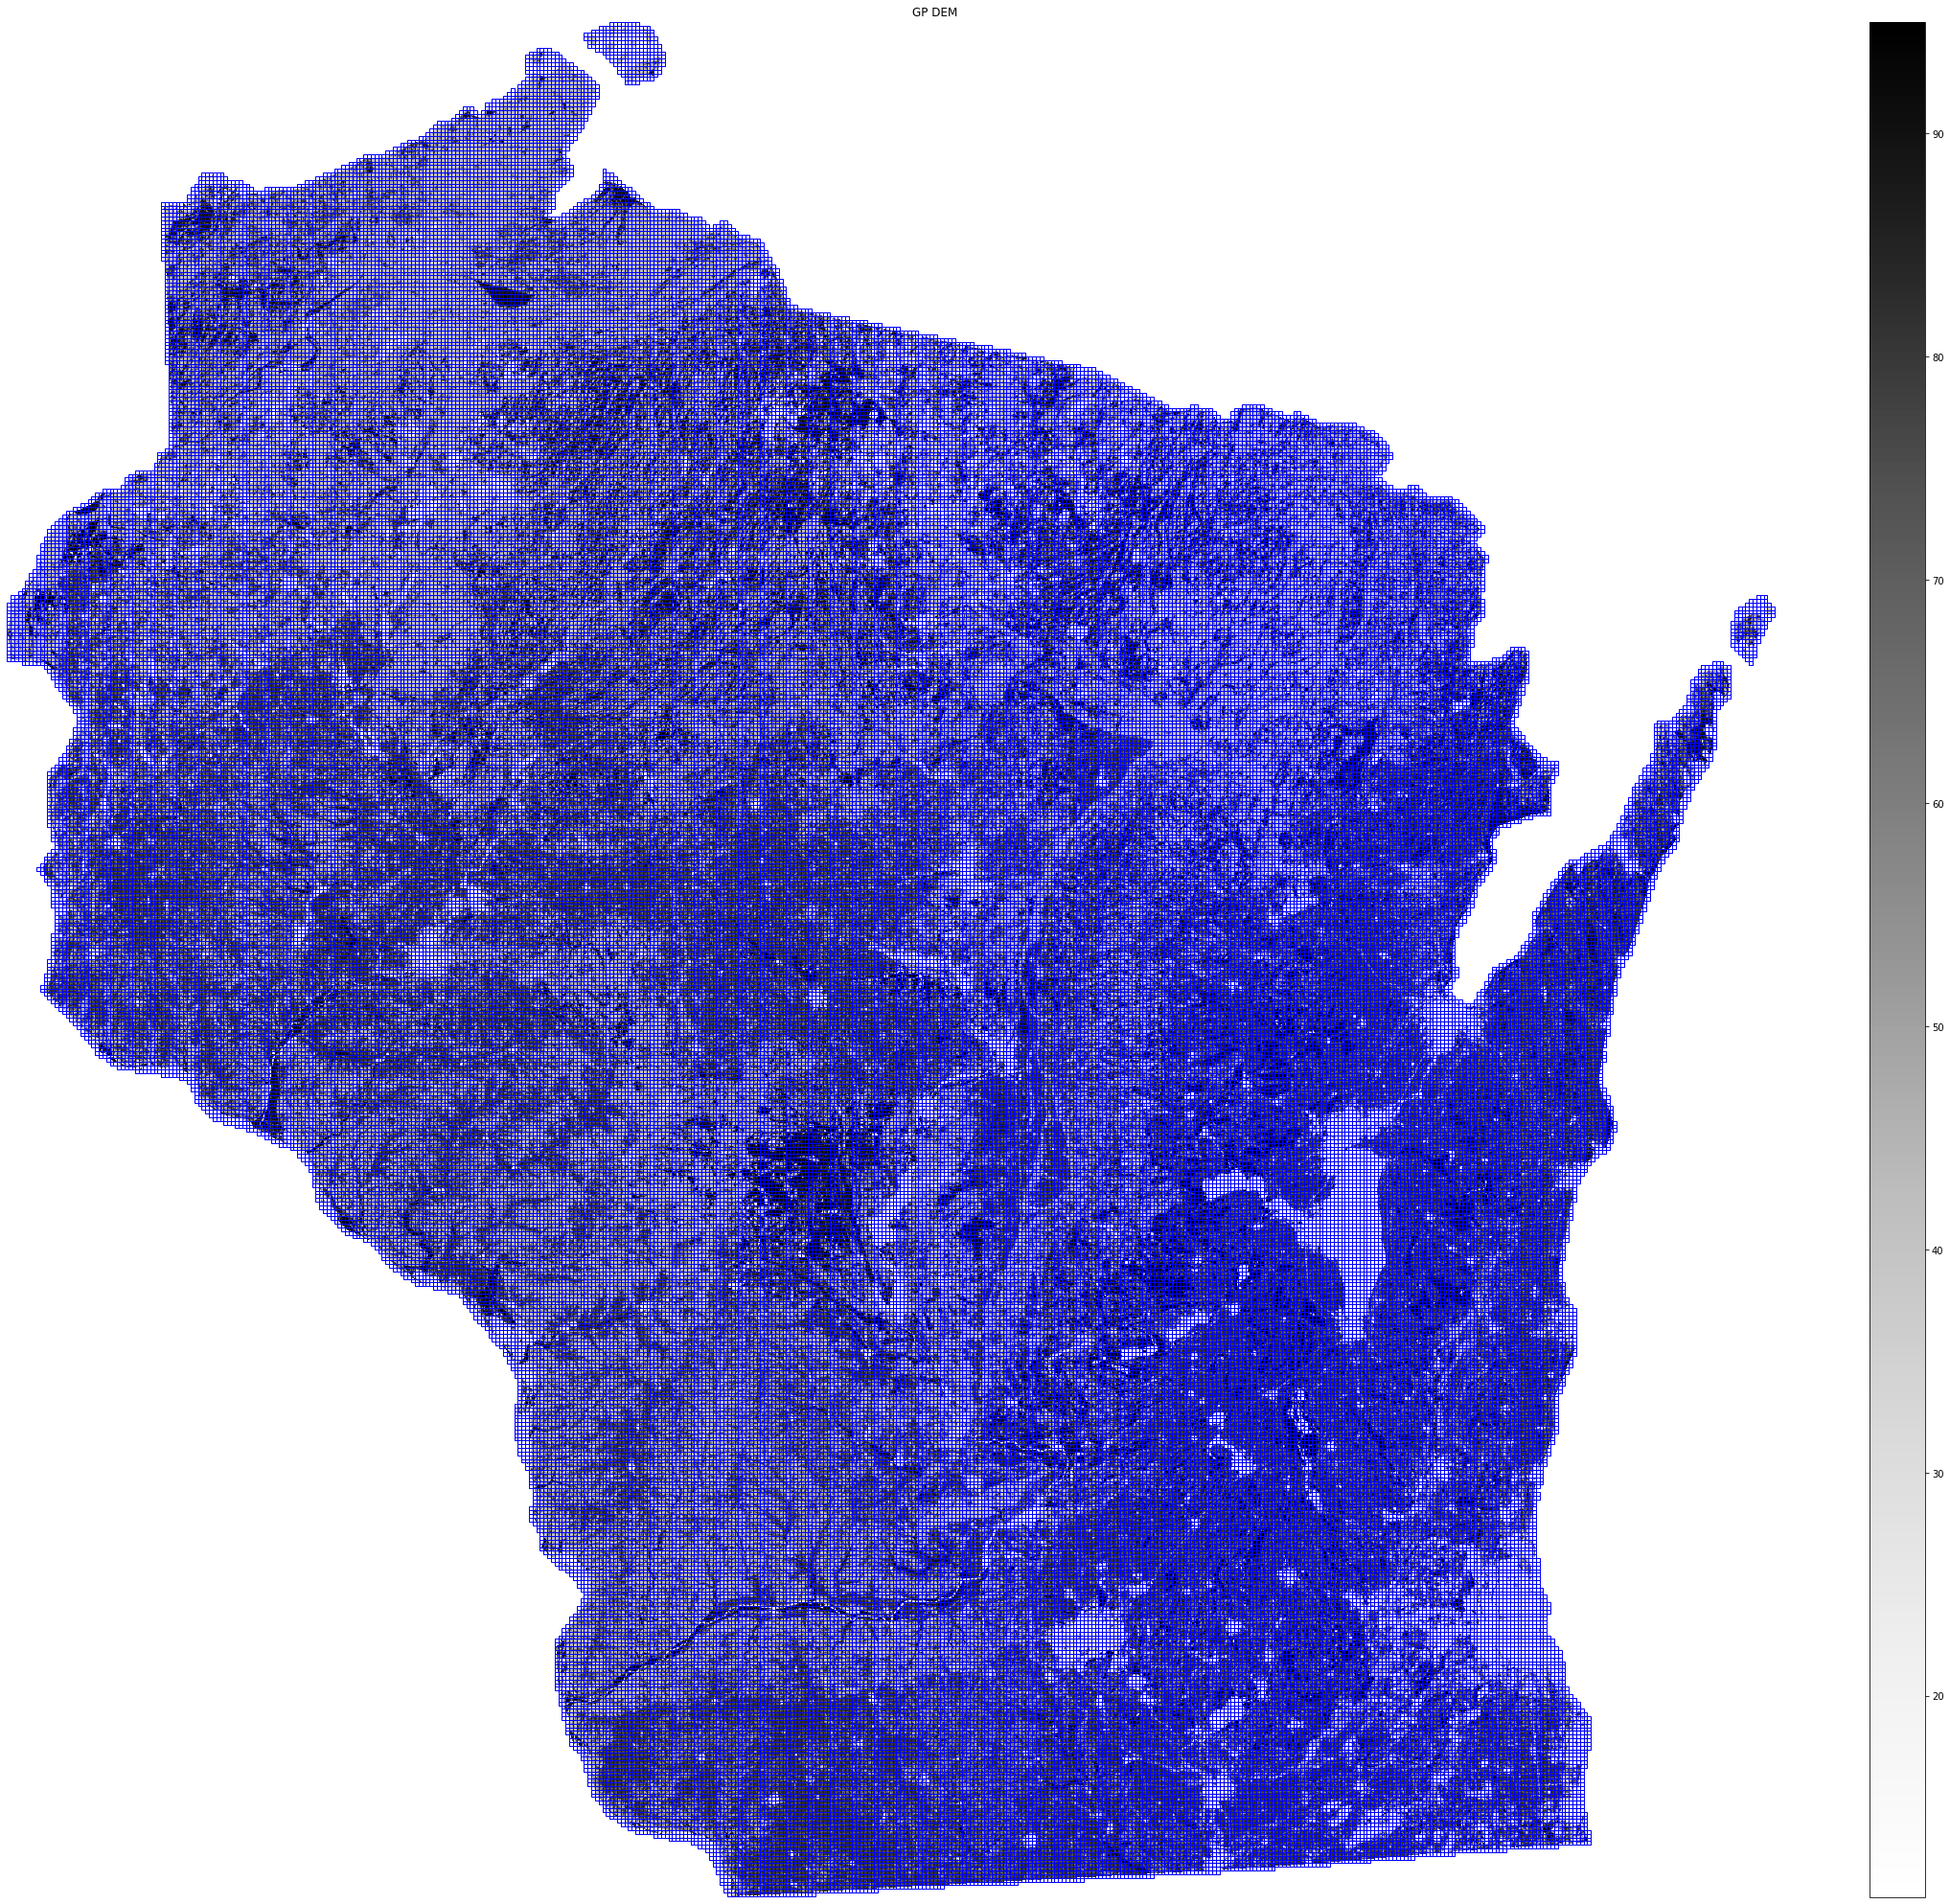

In [152]:
county_BD= gpd.GeoDataFrame.from_file(SHAPEFILE)
county_BD.geom_type.head()

fig, ax = plt.subplots(figsize=(36, 36))

ep.plot_bands(DEM_data,
              # Here you must set the spatial extent or else the data will not line up with your geopandas layer
              extent=plotting_extent(DEM_src),
              cmap='Greys',
              title="GP DEM",
              scale=True,
              ax=ax)
county_BD.plot(ax=ax,
               edgecolor='blue',
              facecolor='none')
ax.set_axis_off()
plt.show()